In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import curve_fit
import datetime

$$H_R = \frac{i\eta\Omega}{2}\left(\sigma_+a+\sigma_-a^\dagger\right)$$
$$H_B = \frac{i\eta\Omega}{2}\left(\sigma_-a+\sigma_+a^\dagger\right)$$

$$\left|0\right>\otimes\left|\overline{n}\right>$$

$$\frac{P_{R, e}(t)}{P_{B, e}(t)-P_{R, e}(t)}$$

$$\overline{n}\approx 5$$

## Read the file

In [2]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, PMT1, PMT1_raw, PMT1_bottom, PMT1_top, PMT2, PMT2_raw, PMT2_bottom, PMT2_top \
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, skiprows=0,unpack=True)
    return x, PMT1

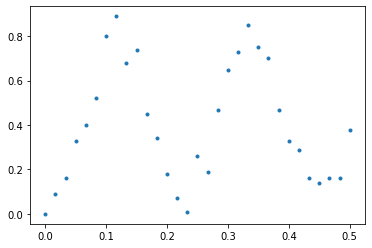

In [3]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_001')
plt.plot(xb, BSB, '.')

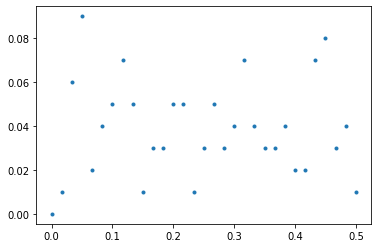

In [4]:
xr, RSB = readFile('RamanTimeScan_CounterProp_RSB_Tilt_001')
plt.plot(xr, RSB, '.')

## Define Hamiltonian

In [5]:
times = xb
nMax = 20

In [6]:
def H(n, isRed = True, Gamma = 0, etaOmega = 5*2*np.pi, times = times):
    H_R = etaOmega/2*(qt.tensor(qt.sigmap(), qt.destroy(nMax))+qt.tensor(qt.sigmam(), qt.create(nMax)))
    H_B = etaOmega/2*(qt.tensor(qt.sigmam(), qt.destroy(nMax))+qt.tensor(qt.sigmap(), qt.create(nMax)))
    
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.thermal_dm(nMax, n))
    psi_1 = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.thermal_dm(nMax, n))

    c_ops = [
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
    if isRed == True:
        result = qt.mesolve(H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    else:
        result = qt.mesolve(H_B, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    
    return result.expect[0]

### Test the Hamiltonian

(0, 1)

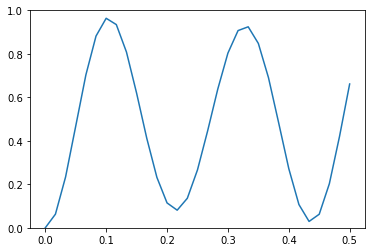

In [7]:
H0 = []
n0 = 0.1
etaOmega = 29
for t in xb:
    H0.append(H(n0, False, 0, etaOmega, [0,t])[-1]) # Test Blue sideband
plt.plot(xb,H0)
plt.ylim([0,1])

## Define heating rate fit

In [63]:
def Heating(x, a, b):
    return a * x + b
def heatingFit(xdata, ydata):
    popt, pcov = curve_fit(Heating, xdata, ydata)
    print(popt[0])
    print(popt[1])
    fitY = [Heating(x, popt[0], popt[1]) for x in xdata]
    plt.plot(xdata, fitY, 'b-')
    plt.plot(xdata, ydata, 'r.', label='data')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Motional quanta')
    plt.show()

## Method 1: Curve fit

In [28]:
def Red(x, n0, etaOmega):
    return H(n0, True, 0, etaOmega, x)
def Blue(x, n0, etaOmega):
    return H(n0, False, 0, etaOmega, x)

In [10]:
def FitRed(xdata, ydata, guess):
    popt, pcov = curve_fit(Red, xdata, ydata, guess)
    plt.plot(xdata, Red(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.plot(xdata, ydata, 'b.', label='data')
    plt.legend()
    print(popt)
    return Red(xdata, *popt)
    
def FitBlue(xdata, ydata, guess):
    popt, pcov = curve_fit(Blue, xdata, ydata, guess)
    plt.plot(xdata, Blue(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.plot(xdata, ydata, 'b.', label='data')
    plt.legend()
    plt.show()
    print(popt)
    return popt

[ 0.0608218  23.01378048]


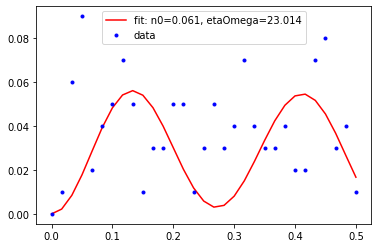

In [14]:
### RSB
xdata = xr
ydata = RSB
guess = np.array([0.1, 27])
RSB_fit = FitRed(xdata, ydata, guess)

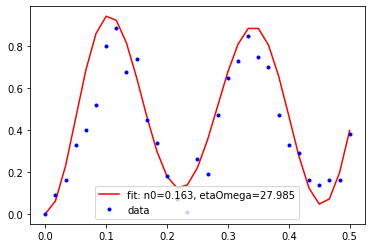

[ 0.16300229 27.98506231]


In [13]:
### BSB
xdata = xb
ydata = BSB
guess = np.array([0.4, 29])
BSB_fit = FitBlue(xdata, ydata, guess)

#### Fit with curve_fit

The loop fitting doesn't work well because it's highly sensitive to the initial guess. We need to change it mannually

## RF = 750

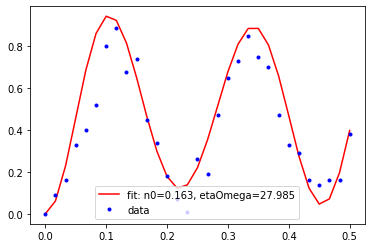

[ 0.16300699 27.98505682]


In [26]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_001')
guess = np.array([0.01, 27])
BSB_fit = FitBlue(xb, BSB, guess)

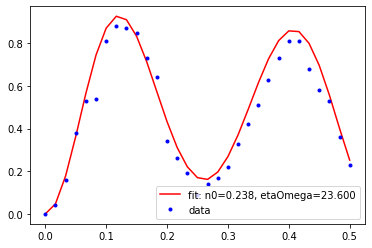

[ 0.23799614 23.60044891]


In [18]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_002')
guess = np.array([0.1, 27])
BSB_fit = FitBlue(xb, BSB, guess)

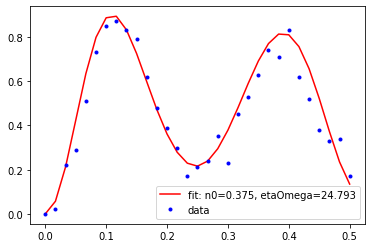

[ 0.37531797 24.79298927]


In [20]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_003')
guess = np.array([1, 27])
BSB_fit = FitBlue(xb, BSB, guess)

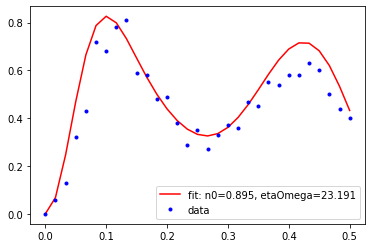

[ 0.8945511  23.19064514]


In [21]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_004')
guess = np.array([1, 30])
BSB_fit = FitBlue(xb, BSB, guess)

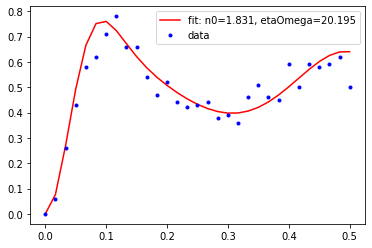

[ 1.83089208 20.19496167]


In [23]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_005')
guess = np.array([1, 30])
BSB_fit = FitBlue(xb, BSB, guess)

20.208100800227616
0.07390142891935622


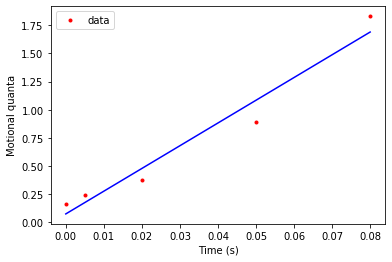

In [64]:
T = [0, 0.005, 0.02, 0.05, 0.08]
n750 = [0.16300548, 0.23799614, 0.37531797, 0.8945511, 1.83089208]
pp = heatingFit(T, n750)

In [58]:
fitY

[0.07390142891935622,
 0.17494193292049431,
 0.4780634449239085,
 1.0843064689307371,
 1.6905494929375655]

In [45]:
popt

array([20.2081008 ,  0.07390143])

In [46]:
popt[0]

20.208100800227616